In [1]:
import pathlib
import numpy as np
import pandas as pd

from obspy import read, UTCDateTime, Stream

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Ellipse
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle

from quakemigrate.io import (read_lut, read_marginal_coalescence, 
                             read_stations)
from quakemigrate.signal.onsets.stalta import pre_process
import quakemigrate.util as util

%matplotlib inline

# style setup and i/o

In [2]:
plt.style.use("../../qm_manuscript.mplstyle")
plt.rcParams.update({"font.family": "Helvetica"})

lut = read_lut(lut_file="./generate_results/outputs/lut/askja.LUT")

run_dir = pathlib.Path.cwd() / "generate_results/outputs/runs/24h_run"

marginalised_coa_map = read_marginal_coalescence(
    run_dir / "locate/marginalised_coalescence_maps/20111026180216820.npy"
)

event = pd.read_csv(
    run_dir / "locate/events/20111026180216820.event"
)

xy_files = pd.read_csv("./generate_results/inputs/XY_FILES/askja_xyfiles.csv",
                       names=["File", "Color",
                              "Linewidth", "Linestyle"],
                       header=None, comment="#")

# pre-proc

In [3]:
# Extract indices and grid coordinates of maximum coalescence
coa_map = np.ma.masked_invalid(marginalised_coa_map)
idx_max = np.column_stack(np.where(coa_map == np.nanmax(coa_map)))[0]
slices = [
    coa_map[:, :, idx_max[2]],
    coa_map[:, idx_max[1], :],
    coa_map[idx_max[0], :, :].T
]
otime = UTCDateTime(event["DT"].values[0])

# Plot Figure 10

<ipython-input-4-cef3d98b867d>:299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


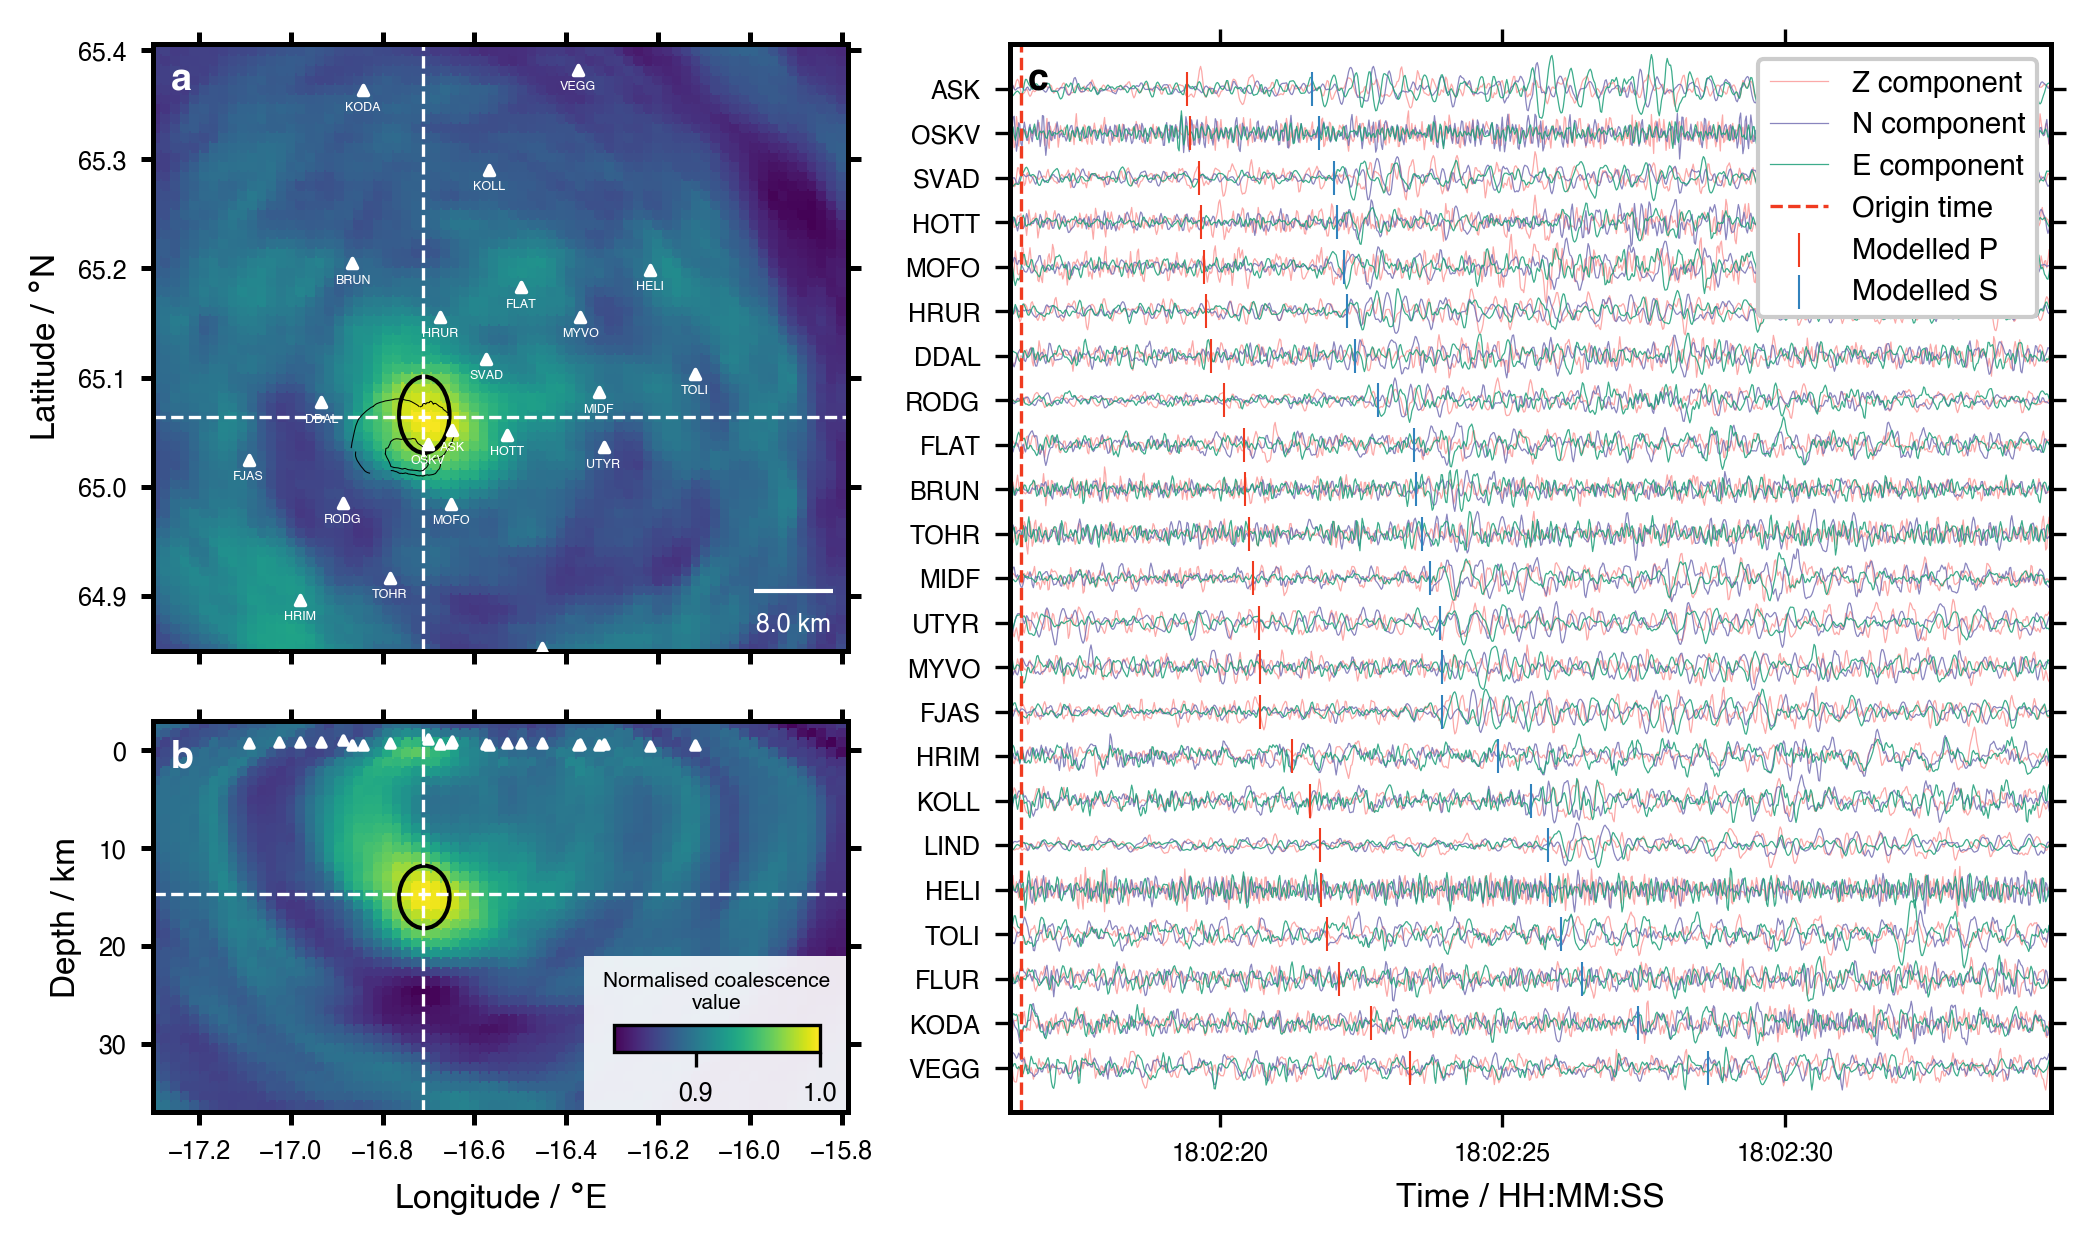

In [4]:
# --- Get aspect ratio ---
# Aspect is defined such that a circle will be stretched so that its
# height is aspect times the width.
cells_extent = lut.get_grid_extent(cells=True)
extent = abs(cells_extent[1] - cells_extent[0])
grid_size = lut.node_spacing * lut.node_count
xy_aspect = (extent[0] * grid_size[1]) / (extent[1] * grid_size[0])

xz_aspect = extent[0] / grid_size[0]

lon_xs_height_ratio = [extent[1], extent[2] / (grid_size[1] / extent[1])]

map_lon_fig_ratio = sum(lon_xs_height_ratio) * xy_aspect / extent[0]

# Set width ratio for coa-map / waveform gather axes
waveform_gather_width_ratio = 1.5

# Setup figure
fig_width = 180 / 25.4  # Seismica full-width = 180; half-width = 86 mm
fig_height = 1.04 * fig_width * map_lon_fig_ratio / (1 + waveform_gather_width_ratio) 

fig = plt.figure(figsize=(fig_width, fig_height), dpi=300, facecolor="w")


# GridSpec
gs = GridSpec(nrows=2, ncols=2,
              height_ratios=lon_xs_height_ratio,
              width_ratios=[1, waveform_gather_width_ratio])


# Setup axes
xy = fig.add_subplot(gs[0, 0], aspect=xy_aspect,
                     adjustable="box",anchor="NE")
xz = fig.add_subplot(gs[1, 0], aspect=xz_aspect,
                     adjustable="box", anchor="SE",
                     sharex=xy)

wg = fig.add_subplot(gs[:, 1], anchor="W")


# --- Plot marginalised coalesence map & best-fit location ---
station_clr = "white"
hypocentre = [event["X"].values[0],
              event["Y"].values[0],
              event["Z"].values[0]]

bounds = [lut.grid_extent[:, 0],
          lut.grid_extent[:, 1],
          lut.grid_extent[:, 2]]
for i, j, ax in [(0, 1, xy), (0, 2, xz)]:
    gminx, gmaxx = bounds[i]
    gminy, gmaxy = bounds[j]

    ax.set_xlim([gminx, gmaxx])
    ax.set_ylim([gminy, gmaxy])

    # --- Plot crosshair for event hypocentre ---
    if hypocentre is not None:
        ax.axvline(x=hypocentre[i], ls="--", lw=0.8, c="white")
        ax.axhline(y=hypocentre[j], ls="--", lw=0.8, c="white")

    slice_ = slices[i + j - 1]
    nx, ny = [dim + 1 for dim in slice_.shape]
    grid1, grid2 = np.mgrid[gminx:gmaxx:nx*1j, gminy:gmaxy:ny*1j]
    sc = ax.pcolormesh(grid1, grid2, slice_,
                       edgecolors="face", cmap="viridis")

# --- Add colourbar ---
xz.add_patch(Rectangle((0.62, 0.0), 0.38, 0.4,
                       facecolor="w", edgecolor=None,
                       alpha=0.9, transform=xz.transAxes))

cax = inset_axes(xz, width="30%", height="7%",
                 bbox_to_anchor=(0, 0.1, 0.99, 1),
                 bbox_transform=xz.transAxes, loc="lower right")
fig.colorbar(sc, cax=cax, orientation="horizontal")
cax.set_xlabel("Normalised coalescence\nvalue", rotation=0, fontsize=5)
cax.xaxis.set_label_position("top")

# --- Plot stations ---
xy.scatter(
    lut.station_data.Longitude.values,
    lut.station_data.Latitude.values,
    s=5, marker="^", zorder=20, c="white",
    label="Stations"
)
xz.scatter(
    lut.station_data.Longitude.values,
    lut.station_data.Elevation.values,
    s=4, marker="^", zorder=20, c="white"
)
for _, row in lut.station_data.iterrows():
    xy.text(row.Longitude, row.Latitude-0.01, row["Name"],
            zorder=20, c=station_clr, fontsize=3,
            ha="center", va="top", clip_on=True)
    
# --- Plot XY files
for _, f in xy_files.iterrows():
    xy_file = pd.read_csv(pathlib.Path.cwd() / "generate_results" / f["File"],
                          names=["Longitude", "Latitude"],
                          header=None, comment="#")
    xy.plot(xy_file["Longitude"].values, xy_file["Latitude"].values,
            ls=f["Linestyle"], lw=f["Linewidth"] / 2,
            c=f["Color"])

# --- Plot uncertainty ellipse ---
error = np.array([event["GAU_ErrX"].values[0],
                  event["GAU_ErrY"].values[0],
                  event["GAU_ErrZ"].values[0]])
gau_hypocentre = [event["GAU_X"].values[0],
                  event["GAU_Y"].values[0],
                  event["GAU_Z"].values[0]]
xyz = lut.coord2grid(gau_hypocentre)[0]
d = abs(gau_hypocentre - lut.coord2grid(xyz + error, inverse=True))[0]

xy_err = Ellipse((gau_hypocentre[0], gau_hypocentre[1]), 2*d[0], 2*d[1], lw=1, edgecolor="k", fill=False,
                 label="Gaussian uncertainty")
xz_err = Ellipse((gau_hypocentre[0], gau_hypocentre[2]), 2*d[0], 2*d[2], lw=1, edgecolor="k", fill=False)
xy.add_patch(xy_err)
xz.add_patch(xz_err)

    
# --- Add scalebar ---
num_cells = np.ceil(lut.node_count[0] / 10)
length = num_cells * lut.node_spacing[0]
size = extent[0] * length / grid_size[0]
scalebar = AnchoredSizeBar(
    xy.transData,
    size=size,
    label=f"{length} {lut.unit_name}",
    loc="lower right",
    pad=0.5,
    sep=5,
    frameon=False,
    color="white",
    fontproperties=fm.FontProperties(size=6)
)
xy.add_artist(scalebar)


# --- Axes labelling ---
xy.tick_params(
    which="both",
    left=True,
    right=True,
    top=True,
    bottom=True,
    labelleft=True,
    labeltop=False,
    labelright=False,
    labelbottom=False,
    size=3,
    width=1.2
)
xy.set_ylabel("Latitude / $\degree$N")
xy.yaxis.set_label_position("left")

xz.invert_yaxis()
xz.tick_params(
    which="both",
    left=True,
    right=True,
    top=True,
    bottom=True,
    labelleft=True,
    labeltop=False,
    labelright=False,
    labelbottom=True,
    size=3,
    width=1.2
)
xz.set_xlabel("Longitude / $\degree$E")
xz.set_ylabel(f"Depth / {lut.unit_name}")
xz.yaxis.set_label_position("left")

plt.setp(xy.spines.values(), linewidth=1.2)
plt.setp(xz.spines.values(), linewidth=1.2)

# Add labels
xy.add_artist(AnchoredText("a", loc="upper left",
              prop={"size": 9, "weight": "bold", "color": "w"},
              frameon=False, borderpad=0.07))
xz.add_artist(AnchoredText("b", loc="upper left",
              prop={"size": 9, "weight": "bold", "color": "w"},
              frameon=False, borderpad=0.07))


### Waveform gather

WAVEFORM_COLOURS1 = ["#FB9A99", "#7570b3", "#1b9e77"]
WAVEFORM_COLOURS2 = ["#33a02c", "#b2df8a", "#1f78b4"]
PICK_COLOURS = ["#F03B20", "#3182BD"]

phases = ["P", "S"]
stations = lut.station_data.Name


# --- Predicted traveltimes ---
traveltimes = np.array([lut.traveltime_to(phase, idx_max, stations)
                        for phase in phases])
arrivals = [[(otime + tt).datetime for tt in tt_f]
            for tt_f in traveltimes]

range_order = abs(np.argsort(np.argsort(arrivals[0]))
                  - len(arrivals[0])) * 2
s = (wg.get_window_extent().height / (max(range_order)+1) * 0.4) ** 2

# Handle single-phase plotting
pick_colours = PICK_COLOURS
if len(phases) == 1:
    if phases[0] == "P":
        pick_colours = [PICK_COLOURS[0]]
for arrival, c, phase in zip(arrivals, pick_colours, phases):
    wg.scatter(arrival, range_order, s=s, c=c, marker="|", zorder=5,
               lw=0.5, label=f"Modelled {phase}")

# --- Read and prep waveforms ---
st = read((run_dir / "locate/raw_cut_waveforms/20111026180216820.m").as_posix())

# pre-proc settings to mirror settings used in 4_locate.py
channel_maps = {"P": "*Z",
                "S": "*[NE12]"}
bandpass_filters = {"P": [2.0, 16.0, 2],
                    "S": [2.0, 14.0, 2]}
sampling_rate = 50.
resample = True
upfactor = 5
starttime = st[0].stats.starttime  # dummy variables - not used here
endtime = st[0].stats.endtime  # dummy variables - not used here

waveforms = Stream()
for phase in phases:
    waveforms += pre_process(st.select(channel=channel_maps[phase]),
                             sampling_rate, resample, upfactor,
                             bandpass_filters[phase],
                             starttime, endtime)

# Min and max times to plot
mint = otime - 0.2
maxt = min(otime + np.max(traveltimes)*1.5, endtime)

# Convert to indices -- will still be the same for sub-sample shifts
times_utc = waveforms[0].times("UTCDateTime")
mint_i, maxt_i = [np.argmin(abs(times_utc - t)) for t in (mint, maxt)]
for i, station in enumerate(stations):
    stn_waveforms = waveforms.select(station=station)
    for c, comp in zip(WAVEFORM_COLOURS1, ["Z", "[N,1]", "[E,2]"]):
        st = stn_waveforms.select(component=comp)
        if not bool(st):
            continue
        tr = st[0]
        comp = tr.stats.component
        data = tr.data

        # Get station specific range for norm factor
        stat_maxt = otime + max(traveltimes[:, i])*1.5
        norm = max(abs(data[mint_i:np.argmin(abs(times_utc - stat_maxt))])) * 1

        # Generate times for plotting
        times = tr.times("matplotlib")[mint_i:maxt_i]

        # Trim to plot limits, normalise, shift by range, then plot
        y = data[mint_i:maxt_i] / norm + range_order[i]
        label = f"{comp} component"
        wg.plot(times, y, c=c, lw=0.3, label=label, alpha=0.85)

# --- Limits, annotations, and axis formatting ---
wg.set_xlim([mint.datetime, maxt.datetime])
wg.set_ylim([0, max(range_order)+2])
wg.xaxis.set_major_formatter(util.DateFormatter("%H:%M:%S", 2))
wg.yaxis.set_ticks(range_order)
wg.yaxis.set_ticklabels(stations)
wg.tick_params(top=True, right=True)

wg.set_xlabel("Time / HH:MM:SS")

# Origin time marker
wg.axvline(otime.datetime, label="Origin time", ls="--", lw=0.8,
           c="#F03B20")

# --- Legend faff ---
handles, labels = wg.get_legend_handles_labels()
for cp1, cp2 in [("N", "1"), ("E", "2")]:
    if all(x in labels for x in [f"{cp1} component", f"{cp2} component"]):
        labels = [f"{cp2}, {cp1} component" if x == f"{cp1} component"
                  or x == f"{cp2} component" else x for x in labels]
by_label = dict(zip(labels, handles))

wg.legend(by_label.values(), by_label.keys(), loc="upper right",
          framealpha=1, markerscale=1, fontsize=7)

# Add label
wg.add_artist(AnchoredText("c", loc="upper left",
              prop={"size": 9, "weight": "bold"},
              frameon=False, borderpad=0.07))

plt.setp(wg.spines.values(), linewidth=1.2)

fig.tight_layout()
